## Support Vector Machines (SVM)

#### Import Modules

In [1]:
# Import Modules and functions
# ----------------------------
from Functions import *
from Modules   import *

#### Read DataFrame

In [2]:
df    = pd.read_csv('..\\Data\\data_train.csv')
X_aim = pd.read_csv('..\\Data\\features_aim.csv')
# --- Clean and prepare data and Aim -----

X_train, X_test, y_train, y_test, X_aim = CLEAN_All_DATA(df, X_aim)

# adding the Kmeans feature
X_train_copy, X_test_copy, X_aim_copy, cat_cols_FE = Kmeans_FE(X_train, X_test, X_aim, cat_cols)

### Load pickle: Best Random Forest-Model

In [3]:

directory_path = r"D:\Visual Studio Code\Used Cars Sales\Pickle"  # use relevant path
filename = "Optimised_GridSearch_RFC_PCA_POLY_FE.p"

# Load the pickled file
pipeline_rfc_poly_pca_FE = pickle.load(open(directory_path + "\\" + filename, "rb"))
pipeline_rfc_best = pipeline_rfc_poly_pca_FE


### Scores and Confusion Matrix

Scoring of GridSearch RFC FE


Model,F1 Score,Recall,Precision,Accuracy
Optimised RFC with POLY/PCA FE,0.434836,0.421986,0.448492,0.858580


-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


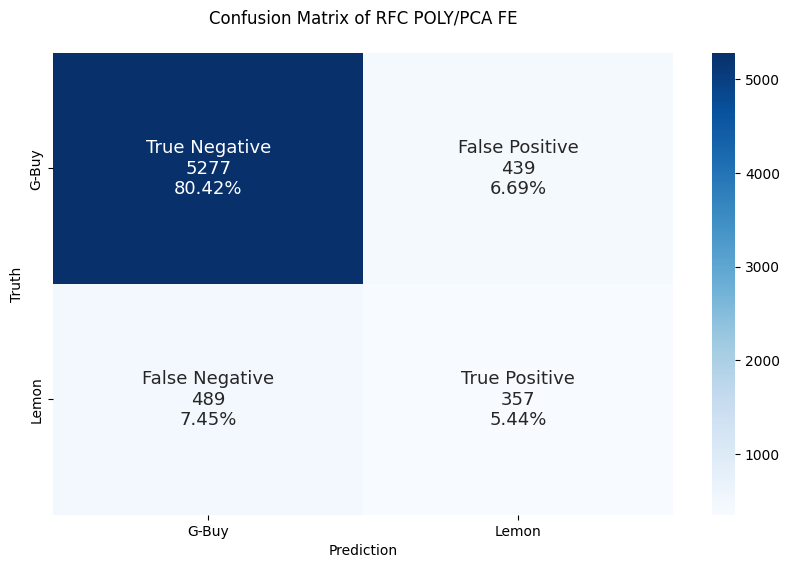

In [4]:
pred_rfc_poly_pca_FE        = pipeline_rfc_poly_pca_FE.predict(X_test_copy) 

f1_rfc_poly_pca_FE          = f1_score(y_test       , pred_rfc_poly_pca_FE)
recall_rfc_poly_pca_FE      = recall_score(y_test   , pred_rfc_poly_pca_FE)
precision_rfc_poly_pca_FE   = precision_score(y_test, pred_rfc_poly_pca_FE)
accuracy_rfc_poly_pca_FE    = accuracy_score(y_test , pred_rfc_poly_pca_FE)



rfc_poly_pca_FE_metrics     = pd.DataFrame({
                                            'Model'    : ['Optimised RFC with POLY/PCA FE'],
                                            'F1 Score' : [f1_rfc_poly_pca_FE],
                                            'Recall'   : [recall_rfc_poly_pca_FE],
                                            'Precision': [precision_rfc_poly_pca_FE],
                                            'Accuracy' : [accuracy_rfc_poly_pca_FE]
                                            })

print('Scoring of GridSearch RFC FE')
display(rfc_poly_pca_FE_metrics.style.hide())
print('-- '*30)
Confusion_Matrix_Func(y_test, pred_rfc_poly_pca_FE, 'RFC POLY/PCA FE');

### Fitting Best Model

In [5]:
# This step is unnecessary when pickle to be loaded,

poly_pca_pipe             = Pipeline([('poly'  , PolynomialFeatures(degree=2)),
                                      ('scaler', StandardScaler()),
                                      ('pca'   , PCA(n_components=.99))
                                    ])

preprocessor              = ColumnTransformer([
                                              ('num', poly_pca_pipe, num_cols),
                                              ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_FE)
                                              ])

rfc                       = RandomForestClassifier(class_weight      = 'balanced',
                                                   random_state      = 442, 
                                                   n_estimators      = 86,
                                                   max_depth         = 36,
                                                   min_samples_leaf  = 2,    
                                                   min_samples_split = 11
                                                 )

pipeline_rfc_best         = Pipeline([('preprocessor', preprocessor),
                                      ('rfClassifier', rfc)
                                     ])

In [6]:
pipeline_rfc_best.fit(X_train_copy, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.99))]),
                                                  ['MMRAcquisitionAuctionAveragePrice',
                                                   'MMRAcquisitionAuctionCleanPrice',
                                                   'MMRAcquisitionRetailAveragePrice',
                                                   'MMRAcquisitonRetailCleanPrice',
                                                   'MMRCurrentAuctionAveragePrice',
                                                   'M...
                                                   'Transmission',
                                                   'Nationality', 'Size',
                                                   'TopThreeAmericanName',
                                                   'IsOnlineSale', 'PRIMEUNIT',
                                                   'AUCGUART', 'BYRNO',
                                                   'VNZIP1', 'VNST',
                                                   'PurchDate_year',
                                                   'PurchDate_month',
                                                   'PurchDate_dayofweek',
                                                   'TransactionCluster'])])),
                ('rfClassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=36,
                                        min_samples_leaf=2,
                                        min_samples_split=11, n_estimators=86,
                                        random_state=442))])

### Extracting important features from the pipeline

In [7]:

ohe_feature_names   = pipeline_rfc_best.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_cols_FE)
all_feature_names   = num_cols + list(ohe_feature_names)[:-2] # temporary incorrect solution [:-2] just because of the mismatch
feature_importances = pipeline_rfc_best.named_steps['rfClassifier'].feature_importances_

feature_importances_df = pd.DataFrame({'feature'   : all_feature_names, 
                                       'importance': feature_importances}
                                      )

feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)


### Plotting Freature Importance (Bar plot)

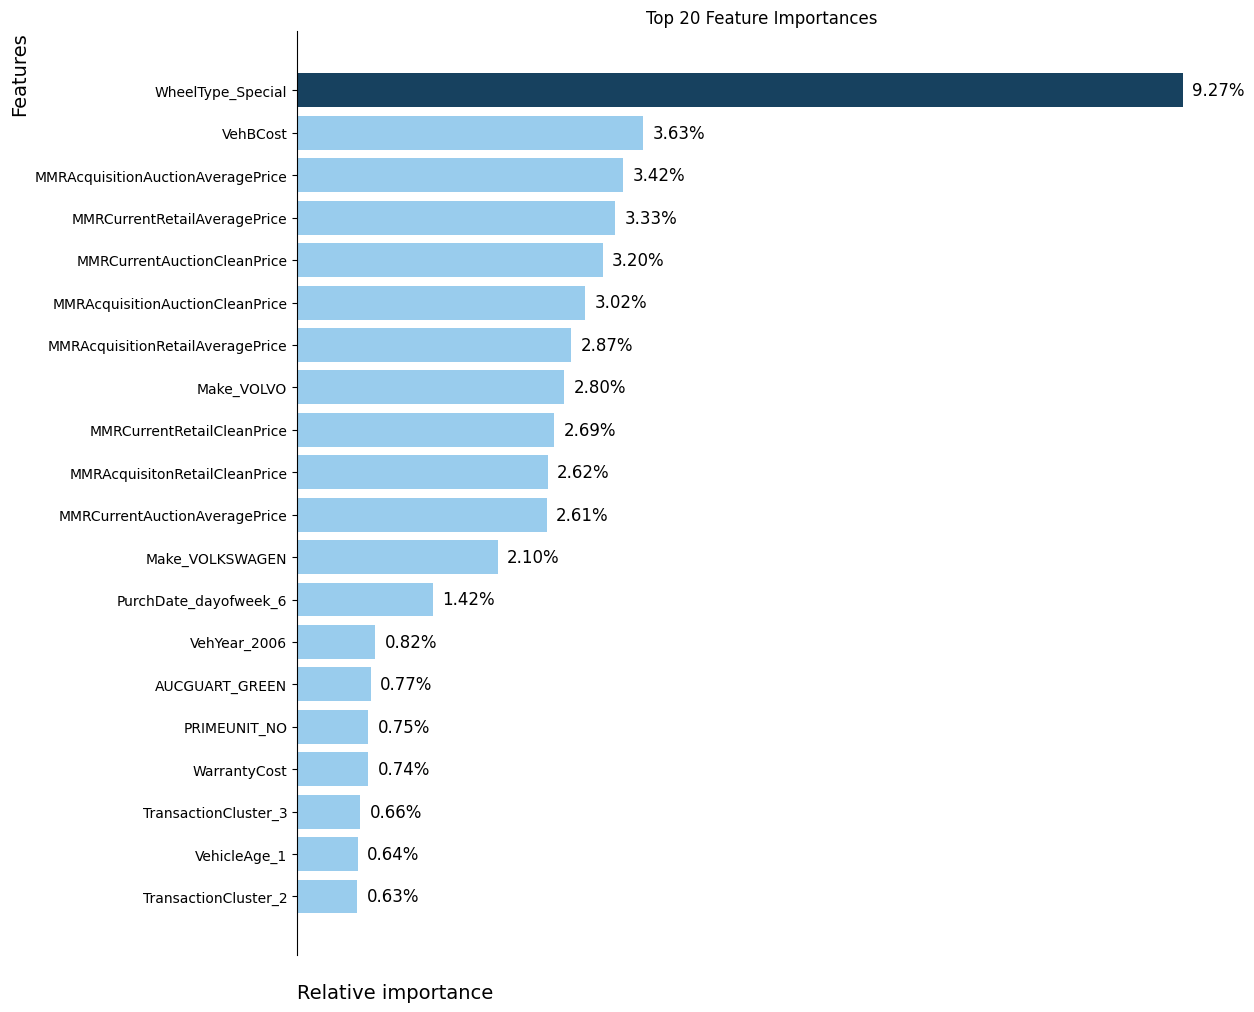

In [9]:
colors = ['#17415f'] + ['#99cced'] * 34

fig, ax = plt.subplots(figsize=(12, 12))
bars    = ax.barh(y     = feature_importances_df['feature'][:20],
                  width = feature_importances_df['importance'][:20],
                  color = colors
                  )

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()

ax.set_xlabel('\nRelative importance',
              size                = 14,
              position            = [0, 0],
              horizontalalignment = 'left')
ax.set_ylabel('Features',
              size                = 14,
              position            = [0, 1],
              horizontalalignment = 'right')
ax.spines[['top', 'right']].set_visible(False)


# Add labels on each bar
for bar, value in zip(bars, feature_importances_df['importance'][:20]):
    ax.text(
        x     = bar.get_width() + 0.001,             # x-coordinate of the text
        y     = bar.get_y() + bar.get_height() / 2,  # y-coordinate of the text
        s     = f'{value:.2%}',                      # Text to be displayed
        ha    = 'left',                              # Horizontal alignment
        va    = 'center',                            # Vertical alignment
        size  = 12,                               
        color = 'black'                          
    )

ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([])

plt.show()


In [10]:
from sklearn.tree import plot_tree

# Extract the RandomForestClassifier from the pipeline
rf_classifier = pipeline_rfc_best.named_steps['rfClassifier']

# Get one of the trees from the RandomForestClassifier
# tree_to_plot = rf_classifier.estimators_[0]  # You can change the index to visualize a different tree

# # Plot the decision tree
# plt.figure(figsize=(20, 10))
# plot_tree(tree_to_plot, filled=True, feature_names=X_train.columns, class_names=['Not Kicked', 'Kicked'], rounded=True)
# plt.show()


In [11]:
rf_classifier

RandomForestClassifier(class_weight='balanced', max_depth=36,
                       min_samples_leaf=2, min_samples_split=11,
                       n_estimators=86, random_state=442)

In [13]:
# from sklearn.tree import export_graphviz
# from pydotplus import graph_from_dot_data

# # Assuming 'pipeline_rfc_best' is your pipeline containing the RandomForestClassifier
# # Change 'X_train.columns' to your actual feature names

# # Extract the RandomForestClassifier from the pipeline
# rf_classifier = pipeline_rfc_best.named_steps['rfClassifier']

# # Choose one of the trees from the RandomForestClassifier
# tree_to_visualize = rf_classifier.estimators_[0]  # You can change the index to visualize a different tree

# # Get feature names
# feature_names = X_train.columns

# # Visualization settings
# tree_layout = export_graphviz(decision_tree=tree_to_visualize,
#                               feature_names=feature_names,
#                               class_names=['Not Kicked', 'Kicked'],
#                               filled=True,
#                               impurity=True)

# tree_graph = graph_from_dot_data(tree_layout)

# # Export to PNG
# tree_graph.write_png('path_to_save/viz_decision_tree.png')  # Change 'path_to_save' to the desired path
